In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive')
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mounted at /content/drive
/bin/bash: line 1: nvidia-smi: command not found
Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
import os
from scipy.stats import skew, kurtosis

# Try clustering with basic statistical features

In [66]:
os.chdir('/content/drive/MyDrive')

# Step 1: Load your data into a pandas DataFrame
# Assuming your DataFrame is named df
df = pd.read_csv('combined_demand_df_1h.csv')
df['timestamp'] = pd.to_datetime(df['time_slot'])
df_notime = df.drop(columns=['time_slot', 'timestamp'], axis=1)
# Convert the entire DataFrame to numeric
df_numeric = df_notime.apply(pd.to_numeric, errors='coerce')

In [67]:
# Step 2: Calculate statistical features for each time series (zone)
# You can use pandas and numpy functions to calculate mean, median, standard deviation, etc.
# Example: Calculate mean for each zone

# All-time
zone_means_all_time = df_numeric.mean(axis=0)
zone_medians_all_time = df_numeric.median(axis=0)
# zone_modes_all_time = df_numeric.mode(axis=0)
zone_std_devs_all_time = df_numeric.std(axis=0)
zone_var_all_time = df_numeric.var(axis=0)
zone_ranges_all_time = df_numeric.max(axis=0) - df_numeric.min(axis=0)
zone_skewness_all_time = df_numeric.skew(axis=0)
zone_kurtosis_all_time = df_numeric.kurtosis(axis=0)

In [68]:
statistical_features_df = pd.DataFrame({
    'mean_all_time': zone_means_all_time,
    'median_all_time': zone_medians_all_time,
    # 'mode_all_time': zone_modes_all_time,
    'std_dev_all_time': zone_std_devs_all_time,
    'var_all_time': zone_var_all_time,
    'range_all_time': zone_ranges_all_time,
    'skewness_all_time': zone_skewness_all_time,
    'kurtosis_all_time': zone_kurtosis_all_time,
    # Add more features as needed
})

In [69]:
# Step 4: Standardize the data
# It's a good practice to standardize your data before clustering
scaler = StandardScaler()
features = statistical_features_df.columns
statistical_features_scaled = scaler.fit_transform(statistical_features_df[features])

## Try with kmeans

In [70]:
# Step 5: Apply clustering algorithm (e.g., KMeans) to group zones into clusters
# Choose the number of clusters (6 in your case)
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
statistical_features_df['cluster'] = kmeans.fit_predict(statistical_features_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [71]:
# Step 6: Evaluate the clustering using silhouette score or other metrics
silhouette_avg = silhouette_score(statistical_features_scaled, statistical_features_df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5043979590902571


In [72]:
# Step 7: Explore the clustered zones
# You can analyze and visualize the clusters as needed
clustered_zones = statistical_features_df.groupby('cluster').apply(lambda x: x.index.tolist())
print("Clustered Zones:")
for i, zones in enumerate(clustered_zones):
    print(f"Cluster {i + 1}: {zones}")

Clustered Zones:
Cluster 1: ['43', '90', '100', '107', '113', '114', '137', '140', '143', '164', '229', '231', '233', '238', '246', '262', '263']
Cluster 2: ['161', '236', '237']
Cluster 3: ['4', '12', '13', '24', '41', '42', '45', '50', '74', '75', '87', '88', '116', '120', '125', '127', '128', '144', '151', '152', '153', '158', '166', '202', '209', '211', '224', '232', '243', '244', '261']
Cluster 4: ['194']
Cluster 5: ['79', '148', '249']
Cluster 6: ['48', '68', '141', '142', '162', '163', '170', '186', '230', '234', '239']


As can be seen above, zone 194 is an outlier. Zone 194 corresponds to Randall's Island, with little roads, hence making it an outlier. Let's remove it and the continue with clustering.

In [73]:
statistical_features_df_dropped_outlier = statistical_features_df.drop('194')

## Dimensionality reduction to see how data is distributed

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

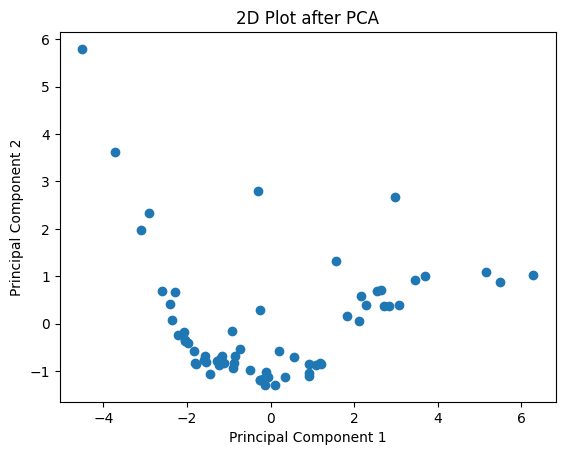

In [75]:
# Step 1: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(statistical_features_df_dropped_outlier)

# Step 2: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Step 3: Create a new DataFrame with the reduced dimensions
df_reduced = pd.DataFrame(data=df_pca, columns=['Principal Component 1', 'Principal Component 2'], index=statistical_features_df_dropped_outlier.index)

# Step 4: Plot the data on a 2D plot
plt.scatter(df_reduced['Principal Component 1'], df_reduced['Principal Component 2'])
plt.title('2D Plot after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Try Spectral Clustering

In [76]:
# Apply spectral clustering
from sklearn.cluster import SpectralClustering

n_clusters = 10  # You can adjust the number of clusters based on your data
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
statistical_features_df_dropped_outlier['cluster'] = spectral_clustering.fit_predict(df_scaled)


In [77]:
# Step 6: Evaluate the clustering using silhouette score or other metrics
silhouette_avg = silhouette_score(df_scaled, statistical_features_df_dropped_outlier['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.43951615758221624


In [78]:
statistical_features_df_dropped_outlier

,mean_all_time,median_all_time,std_dev_all_time,var_all_time,range_all_time,skewness_all_time,kurtosis_all_time,cluster
4,5.092250,3.0,7.234677,52.340555,78.0,4.057958,21.456617,3
12,1.681296,0.0,2.816058,7.930183,27.0,2.427855,7.178984,3
13,23.323419,19.0,21.386085,457.364645,111.0,0.648357,-0.587599,4
24,13.067787,13.0,9.740764,94.882476,63.0,0.406765,-0.631320,0
41,13.623262,12.0,10.211069,104.265930,70.0,0.756278,0.246961,0
...,...,...,...,...,...,...,...,...
246,61.948011,56.0,50.159207,2515.946032,350.0,0.825853,0.459407,8
249,87.102084,75.0,68.938618,4752.532985,658.0,1.595729,3.937680,9
261,19.741990,15.0,17.465276,305.035879,102.0,0.754021,-0.317981,0
262,56.424979,53.0,44.860237,2012.440819,203.0,0.309625,-1.163215,1


In [79]:
df_reduced

,Principal Component 1,Principal Component 2
4,-2.909388,2.339227
12,-2.412986,0.413007
13,-1.122573,-0.824373
24,-1.457221,-1.056931
41,-1.534052,-0.815378
...,...,...
246,0.211830,-0.575218
249,1.557738,1.316274
261,-1.287279,-0.787926
262,-0.067811,-1.129036


In [80]:
df_reduced['cluster'] = statistical_features_df_dropped_outlier['cluster']
df_reduced

,Principal Component 1,Principal Component 2,cluster
4,-2.909388,2.339227,3
12,-2.412986,0.413007,3
13,-1.122573,-0.824373,4
24,-1.457221,-1.056931,0
41,-1.534052,-0.815378,0
...,...,...,...
246,0.211830,-0.575218,8
249,1.557738,1.316274,9
261,-1.287279,-0.787926,0
262,-0.067811,-1.129036,1


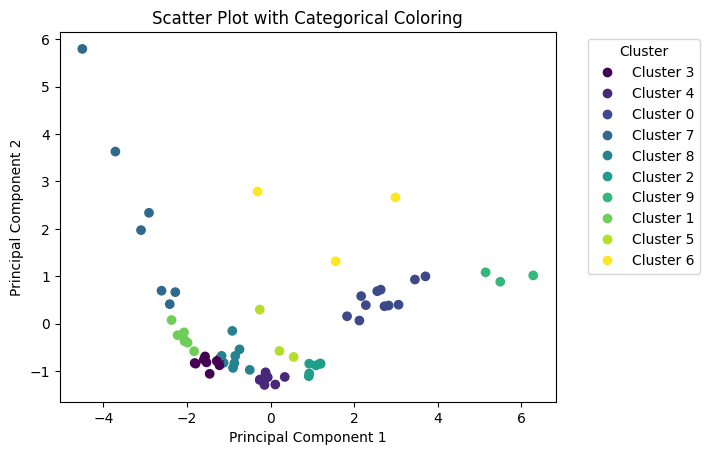

In [81]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame df_reduced with 'Principal Component 1', 'Principal Component 2', and 'cluster' columns

# Scatter plot using Matplotlib
scatter = plt.scatter(df_reduced['Principal Component 1'], df_reduced['Principal Component 2'], c=df_reduced['cluster'].astype('category').cat.codes, cmap='viridis')

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot with Categorical Coloring')

# Add legend outside the plot to the right
legend_labels = df_reduced['cluster'].unique()
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {label}' for label in legend_labels], title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


In [82]:
# Step 7: Explore the clustered zones
# You can analyze and visualize the clusters as needed
clustered_zones = statistical_features_df_dropped_outlier.groupby('cluster').apply(lambda x: x.index.tolist())
print("Clustered Zones:")
for i, zones in enumerate(clustered_zones):
    print(f"Cluster {i}: {zones}")

Clustered Zones:
Cluster 0: ['24', '41', '45', '74', '87', '88', '125', '224', '261']
Cluster 1: ['90', '100', '113', '137', '143', '231', '233', '262']
Cluster 2: ['48', '68', '141', '142', '162', '163', '170', '186', '230', '234', '239']
Cluster 3: ['4', '12', '120', '128', '153', '202', '232']
Cluster 4: ['13', '50', '75', '144', '151', '158', '166', '211']
Cluster 5: ['107', '140', '164', '229', '238', '263']
Cluster 6: ['161', '236', '237']
Cluster 7: ['42', '116', '127', '152', '209', '243', '244']
Cluster 8: ['43', '114', '246']
Cluster 9: ['79', '148', '249']


In [83]:
# Assuming statistical_features_df has 'cluster' column indicating the cluster for each zone
# Assuming kmeans is the trained KMeans model

# Step 8: Find the zone closest to the cluster center for each cluster
closest_zones = []

# Iterate through each cluster
for i in range(n_clusters):
    cluster_zones = statistical_features_df_dropped_outlier[statistical_features_df_dropped_outlier['cluster'] == i].index

    # Calculate the mean of each feature for the cluster
    cluster_center = statistical_features_df_dropped_outlier.loc[cluster_zones, statistical_features_df_dropped_outlier.columns != 'cluster'].mean()

    # Calculate distance between each zone in the cluster and the cluster center
    distances = np.linalg.norm(statistical_features_df_dropped_outlier.loc[cluster_zones, statistical_features_df_dropped_outlier.columns != 'cluster'] - cluster_center, axis=1)

    # Find the zone with the minimum distance (closest to the cluster center)
    closest_zone = cluster_zones[np.argmin(distances)]
    closest_zones.append(closest_zone)

# Display the result
for i, closest_zone in enumerate(closest_zones):
    print(f"Cluster {i} - Closest Zone: {closest_zone}")


Cluster 0 - Closest Zone: 41
Cluster 1 - Closest Zone: 231
Cluster 2 - Closest Zone: 239
Cluster 3 - Closest Zone: 12
Cluster 4 - Closest Zone: 75
Cluster 5 - Closest Zone: 164
Cluster 6 - Closest Zone: 236
Cluster 7 - Closest Zone: 244
Cluster 8 - Closest Zone: 246
Cluster 9 - Closest Zone: 249


# Try with more complex statistical features such as temporal periods

In [84]:
# Step 1: Load your data into a pandas DataFrame
# Assuming your DataFrame is named df
df = pd.read_csv('combined_demand_df_1h.csv')
df_notime = df.drop(columns=['time_slot'], axis=1)
# Convert the entire DataFrame to numeric
df_numeric = df_notime.apply(pd.to_numeric, errors='coerce')

In [85]:
from datetime import datetime

# Convert 'timestamp_str' to datetime format
df['time_slot'] = pd.to_datetime(df['time_slot'])

# Assuming 'timestamp' is a datetime column
df['day_of_week'] = df['time_slot'].dt.dayofweek

df

,time_slot,4,12,13,24,41,42,43,45,48,...,238,239,243,244,246,249,261,262,263,day_of_week
0,2021-01-01 00:00:00,3.0,0.0,3.0,7.0,5.0,2.0,22.0,4.0,81.0,...,39.0,28.0,0.0,2.0,9.0,20.0,2.0,15.0,54.0,4
1,2021-01-01 01:00:00,1.0,0.0,2.0,4.0,22.0,14.0,6.0,0.0,72.0,...,27.0,44.0,1.0,3.0,12.0,32.0,6.0,18.0,49.0,4
2,2021-01-01 02:00:00,2.0,0.0,2.0,2.0,11.0,9.0,5.0,0.0,63.0,...,23.0,21.0,0.0,3.0,13.0,17.0,5.0,7.0,27.0,4
3,2021-01-01 03:00:00,3.0,0.0,0.0,2.0,3.0,7.0,2.0,1.0,31.0,...,10.0,8.0,0.0,1.0,3.0,10.0,1.0,2.0,12.0,4
4,2021-01-01 04:00:00,0.0,0.0,0.0,2.0,8.0,4.0,0.0,0.0,20.0,...,4.0,6.0,0.0,2.0,4.0,3.0,2.0,1.0,10.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24808,2023-10-31 19:00:00,2.0,0.0,37.0,6.0,27.0,4.0,51.0,12.0,140.0,...,179.0,199.0,1.0,0.0,105.0,147.0,23.0,80.0,126.0,1
24809,2023-10-31 20:00:00,5.0,0.0,37.0,10.0,12.0,1.0,88.0,7.0,128.0,...,119.0,191.0,1.0,1.0,93.0,159.0,26.0,67.0,112.0,1
24810,2023-10-31 21:00:00,3.0,0.0,27.0,10.0,4.0,4.0,49.0,7.0,161.0,...,76.0,176.0,0.0,0.0,88.0,184.0,16.0,35.0,99.0,1
24811,2023-10-31 22:00:00,9.0,0.0,14.0,9.0,12.0,4.0,37.0,11.0,175.0,...,36.0,94.0,0.0,0.0,53.0,190.0,12.0,21.0,60.0,1


In [86]:
# Melt the DataFrame to have a long format
melted_df = pd.melt(df, id_vars=['time_slot', 'day_of_week'], var_name='zone', value_name='demand')

# Group by 'zone' and 'day_of_week' and calculate the average demand for each group
average_demand_df = melted_df.groupby(['zone', melted_df['time_slot'].dt.dayofweek]).mean().reset_index()

# Pivot the table to get the desired format
pivot_df = average_demand_df.pivot(index='zone', columns='time_slot', values='demand')

# Flatten the MultiIndex columns for easy access
pivot_df.columns = [f"day_{day}_demand" for day in pivot_df.columns.get_level_values('time_slot')]

pivot_df

<ipython-input-86-5f7292858dc3>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_demand_df = melted_df.groupby(['zone', melted_df['time_slot'].dt.dayofweek]).mean().reset_index()


,day_0_demand,day_1_demand,day_2_demand,day_3_demand,day_4_demand,day_5_demand,day_6_demand
zone,,,,,,,
100,65.299550,73.243525,76.379252,75.394841,68.136261,61.302365,52.279797
107,73.388795,88.921734,97.770408,102.669501,106.615991,110.672297,81.582699
113,45.949324,54.169764,58.027494,59.528912,60.615428,63.603322,46.816568
114,32.780405,38.360642,42.595238,47.128401,56.267455,73.845721,55.152437
116,3.614020,3.917511,4.035714,4.356576,4.897804,4.514921,3.948154
...,...,...,...,...,...,...,...
75,29.264640,33.280405,34.135488,34.754535,35.412444,28.000563,22.762468
79,60.128941,70.421453,80.910998,91.009921,117.289414,170.722973,129.392505
87,17.162444,20.992399,23.334467,25.482993,25.165541,25.803773,18.470555


In [87]:
# Step 4: Standardize the data
# It's a good practice to standardize your data before clustering
scaler = StandardScaler()
features = pivot_df.columns
pivot_df_scaled = scaler.fit_transform(pivot_df[features])

## Try with kmeans

In [88]:
# Step 5: Apply clustering algorithm (e.g., KMeans) to group zones into clusters
# Choose the number of clusters (6 in your case)
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pivot_df['cluster'] = kmeans.fit_predict(pivot_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [89]:
# Step 6: Evaluate the clustering using silhouette score or other metrics
silhouette_avg = silhouette_score(pivot_df_scaled, pivot_df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.543261452151171


In [90]:
# Step 7: Explore the clustered zones
# You can analyze and visualize the clusters as needed
clustered_zones = pivot_df.groupby('cluster').apply(lambda x: x.index.tolist())
print("Clustered Zones:")
for i, zones in enumerate(clustered_zones):
    print(f"Cluster {i + 1}: {zones}")

Clustered Zones:
Cluster 1: ['161', '236', '237']
Cluster 2: ['116', '12', '120', '127', '128', '152', '153', '194', '202', '209', '224', '232', '24', '243', '244', '4', '41', '42', '45', '74', '88']
Cluster 3: ['107', '140', '164', '229', '238', '249', '263', '68', '79']
Cluster 4: ['100', '113', '114', '137', '143', '231', '233', '246', '262', '43', '90']
Cluster 5: ['141', '142', '162', '163', '170', '186', '230', '234', '239', '48']
Cluster 6: ['125', '13', '144', '148', '151', '158', '166', '211', '261', '50', '75', '87']


## Dimensionality reduction

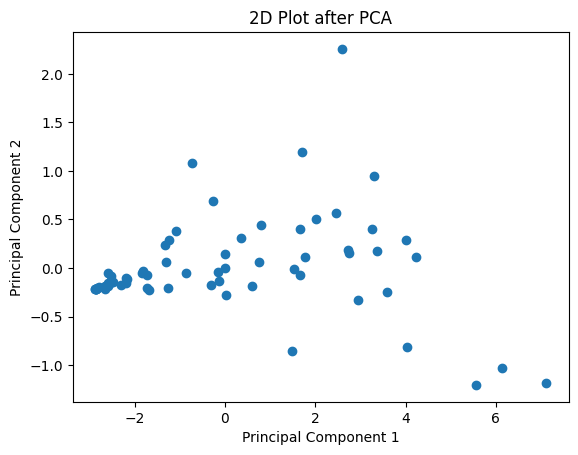

In [91]:
# Step 2: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
df_pca = pca.fit_transform(pivot_df_scaled)

# Step 3: Create a new DataFrame with the reduced dimensions
df_reduced = pd.DataFrame(data=df_pca, columns=['Principal Component 1', 'Principal Component 2'], index=pivot_df.index)

# Step 4: Plot the data on a 2D plot
plt.scatter(df_reduced['Principal Component 1'], df_reduced['Principal Component 2'])
plt.title('2D Plot after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Spectral Clustering

In [92]:
# Apply spectral clustering
from sklearn.cluster import SpectralClustering

n_clusters = 6  # You can adjust the number of clusters based on your data
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
df_reduced['cluster'] = spectral_clustering.fit_predict(pivot_df_scaled)

In [93]:
# Step 6: Evaluate the clustering using silhouette score or other metrics
silhouette_avg = silhouette_score(pivot_df_scaled, pivot_df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.543261452151171


In [94]:
df_reduced['cluster'] = pivot_df['cluster']
df_reduced

,Principal Component 1,Principal Component 2,cluster
zone,,,
100,0.602038,-0.187692,3
107,2.025345,0.505764,2
113,0.003868,0.142988,3
114,-0.266437,0.687325,3
116,-2.653261,-0.184894,1
...,...,...,...
75,-1.272644,-0.210078,5
79,2.593042,2.257397,2
87,-1.716673,-0.066975,5


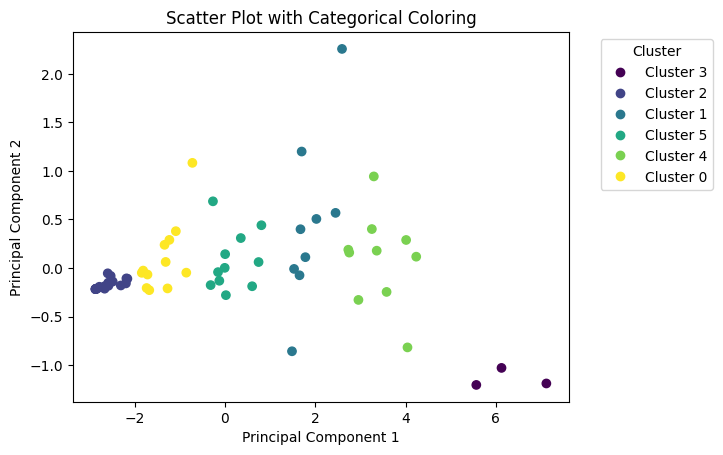

In [95]:
# Assuming you have a DataFrame df_reduced with 'Principal Component 1', 'Principal Component 2', and 'cluster' columns

# Scatter plot using Matplotlib
scatter = plt.scatter(df_reduced['Principal Component 1'], df_reduced['Principal Component 2'], c=df_reduced['cluster'].astype('category').cat.codes, cmap='viridis')

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot with Categorical Coloring')

# Add legend outside the plot to the right
legend_labels = df_reduced['cluster'].unique()
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {label}' for label in legend_labels], title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [96]:
# Step 7: Explore the clustered zones
# You can analyze and visualize the clusters as needed
clustered_zones = pivot_df.groupby('cluster').apply(lambda x: x.index.tolist())
print("Clustered Zones:")
for i, zones in enumerate(clustered_zones):
    print(f"Cluster {i}: {zones}")

Clustered Zones:
Cluster 0: ['161', '236', '237']
Cluster 1: ['116', '12', '120', '127', '128', '152', '153', '194', '202', '209', '224', '232', '24', '243', '244', '4', '41', '42', '45', '74', '88']
Cluster 2: ['107', '140', '164', '229', '238', '249', '263', '68', '79']
Cluster 3: ['100', '113', '114', '137', '143', '231', '233', '246', '262', '43', '90']
Cluster 4: ['141', '142', '162', '163', '170', '186', '230', '234', '239', '48']
Cluster 5: ['125', '13', '144', '148', '151', '158', '166', '211', '261', '50', '75', '87']


In [97]:
pivot_df

,day_0_demand,day_1_demand,day_2_demand,day_3_demand,day_4_demand,day_5_demand,day_6_demand,cluster
zone,,,,,,,,
100,65.299550,73.243525,76.379252,75.394841,68.136261,61.302365,52.279797,3
107,73.388795,88.921734,97.770408,102.669501,106.615991,110.672297,81.582699,2
113,45.949324,54.169764,58.027494,59.528912,60.615428,63.603322,46.816568,3
114,32.780405,38.360642,42.595238,47.128401,56.267455,73.845721,55.152437,3
116,3.614020,3.917511,4.035714,4.356576,4.897804,4.514921,3.948154,1
...,...,...,...,...,...,...,...,...
75,29.264640,33.280405,34.135488,34.754535,35.412444,28.000563,22.762468,5
79,60.128941,70.421453,80.910998,91.009921,117.289414,170.722973,129.392505,2
87,17.162444,20.992399,23.334467,25.482993,25.165541,25.803773,18.470555,5


In [98]:
n_clusters = pivot_df['cluster'].nunique()

In [99]:
# Assuming statistical_features_df has 'cluster' column indicating the cluster for each zone

# Step 8: Find the zone closest to the cluster center for each cluster
closest_zones = []

# Iterate through each cluster
for i in range(n_clusters):
    cluster_zones = pivot_df[pivot_df['cluster'] == i].index

    # Calculate the mean of each feature for the cluster
    cluster_center = pivot_df.loc[cluster_zones, pivot_df.columns != 'cluster'].mean()

    # Calculate distance between each zone in the cluster and the cluster center
    distances = np.linalg.norm(pivot_df.loc[cluster_zones, pivot_df.columns != 'cluster'] - cluster_center, axis=1)

    # Find the zone with the minimum distance (closest to the cluster center)
    closest_zone = cluster_zones[np.argmin(distances)]
    closest_zones.append(closest_zone)

# Display the result
for i, closest_zone in enumerate(closest_zones):
    print(f"Cluster {i} - Closest Zone: {closest_zone}")


Cluster 0 - Closest Zone: 236
Cluster 1 - Closest Zone: 45
Cluster 2 - Closest Zone: 107
Cluster 3 - Closest Zone: 113
Cluster 4 - Closest Zone: 230
Cluster 5 - Closest Zone: 50


# Try with both basic and complex features

In [100]:
statistical_features_df = statistical_features_df.drop(columns=['cluster'])

In [101]:
pivot_df = pivot_df.drop(columns=['cluster'])

In [102]:
new_df = pd.merge(statistical_features_df, pivot_df, left_index=True, right_index=True)
new_df

,mean_all_time,median_all_time,std_dev_all_time,var_all_time,range_all_time,skewness_all_time,kurtosis_all_time,day_0_demand,day_1_demand,day_2_demand,day_3_demand,day_4_demand,day_5_demand,day_6_demand
4,5.092250,3.0,7.234677,52.340555,78.0,4.057958,21.456617,2.572354,3.077421,3.289966,3.957766,5.626971,9.615991,7.487461
12,1.681296,0.0,2.816058,7.930183,27.0,2.427855,7.178984,1.569820,1.471565,1.453231,1.437642,1.675113,2.325732,1.832911
13,23.323419,19.0,21.386085,457.364645,111.0,0.648357,-0.587599,20.610642,25.021396,27.371882,27.897392,24.697354,21.767736,15.949563
24,13.067787,13.0,9.740764,94.882476,63.0,0.406765,-0.631320,11.548986,12.997466,13.564342,14.099490,14.988176,13.267736,11.016906
41,13.623262,12.0,10.211069,104.265930,70.0,0.756278,0.246961,11.642173,12.706363,13.270975,13.979875,16.088119,15.173705,12.500704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,61.948011,56.0,50.159207,2515.946032,350.0,0.825853,0.459407,51.132883,58.892455,62.695862,68.460601,60.936655,73.521959,58.041420
249,87.102084,75.0,68.938618,4752.532985,658.0,1.595729,3.937680,58.958615,70.205518,78.353458,85.441610,98.807432,126.121903,91.759651
261,19.741990,15.0,17.465276,305.035879,102.0,0.754021,-0.317981,17.211993,18.165259,19.886054,20.739229,20.476070,23.282095,18.439842
262,56.424979,53.0,44.860237,2012.440819,203.0,0.309625,-1.163215,53.110923,61.135135,63.644274,65.093821,63.777309,50.206081,38.099183


In [103]:
# Step 4: Standardize the data
# It's a good practice to standardize your data before clustering
scaler = StandardScaler()
features = new_df.columns
new_df_scaled = scaler.fit_transform(new_df[features])

## Try with kmeans

In [104]:
# Step 5: Apply clustering algorithm (e.g., KMeans) to group zones into clusters
# Choose the number of clusters (6 in your case)
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
new_df['cluster'] = kmeans.fit_predict(new_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [105]:
# Step 6: Evaluate the clustering using silhouette score or other metrics
silhouette_avg = silhouette_score(new_df_scaled, new_df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.4601338574536414


In [106]:
# Step 7: Explore the clustered zones
# You can analyze and visualize the clusters as needed
clustered_zones = new_df.groupby('cluster').apply(lambda x: x.index.tolist())
print("Clustered Zones:")
for i, zones in enumerate(clustered_zones):
    print(f"Cluster {i + 1}: {zones}")

Clustered Zones:
Cluster 1: ['161', '236', '237']
Cluster 2: ['50', '75', '100', '113', '114', '137', '143', '144', '148', '151', '158', '211', '231', '233', '246', '262']
Cluster 3: ['48', '79', '141', '142', '162', '163', '170', '186', '230', '234', '239']
Cluster 4: ['4', '12', '13', '24', '41', '42', '45', '74', '87', '88', '116', '120', '125', '127', '128', '152', '153', '166', '202', '209', '224', '232', '243', '244', '261']
Cluster 5: ['194']
Cluster 6: ['43', '68', '90', '107', '140', '164', '229', '238', '249', '263']


In [109]:
## remove outlier first
new_df_dropped_outlier = new_df.drop('194')

## Dimensionality reduction

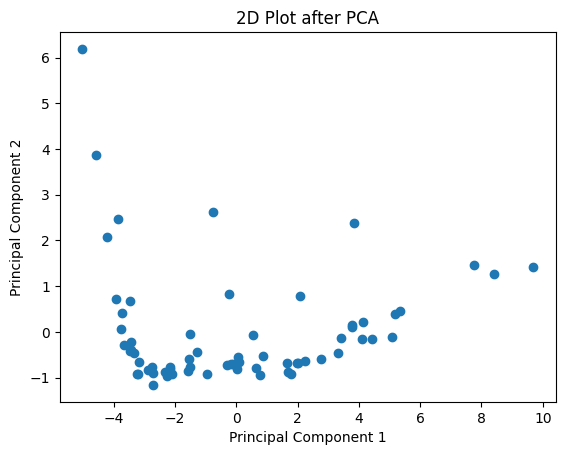

In [110]:
# Step 1: Standardize the data
scaler = StandardScaler()
new_df_scaled = scaler.fit_transform(new_df_dropped_outlier)

# Step 2: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
df_pca = pca.fit_transform(new_df_scaled)

# Step 3: Create a new DataFrame with the reduced dimensions
df_reduced = pd.DataFrame(data=df_pca, columns=['Principal Component 1', 'Principal Component 2'], index=new_df_dropped_outlier.index)

# Step 4: Plot the data on a 2D plot
plt.scatter(df_reduced['Principal Component 1'], df_reduced['Principal Component 2'])
plt.title('2D Plot after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Spectral Clustering

In [120]:
# Apply spectral clustering
from sklearn.cluster import SpectralClustering

n_clusters = 10  # You can adjust the number of clusters based on your data
spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
df_reduced['cluster'] = spectral_clustering.fit_predict(new_df_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [121]:
# Step 6: Evaluate the clustering using silhouette score or other metrics
silhouette_avg = silhouette_score(new_df_scaled, new_df_dropped_outlier['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5048826506439932


In [122]:
df_reduced['cluster'] = new_df_dropped_outlier['cluster']
df_reduced

,Principal Component 1,Principal Component 2,cluster
4,-3.870051,2.469603,3
12,-3.738118,0.409033,3
13,-2.086052,-0.914695,3
24,-2.703177,-1.160025,3
41,-2.723003,-0.899782,3
...,...,...,...
246,0.535784,-0.078707,1
249,2.073199,0.781924,5
261,-2.319081,-0.869563,3
262,0.092591,-0.662829,1


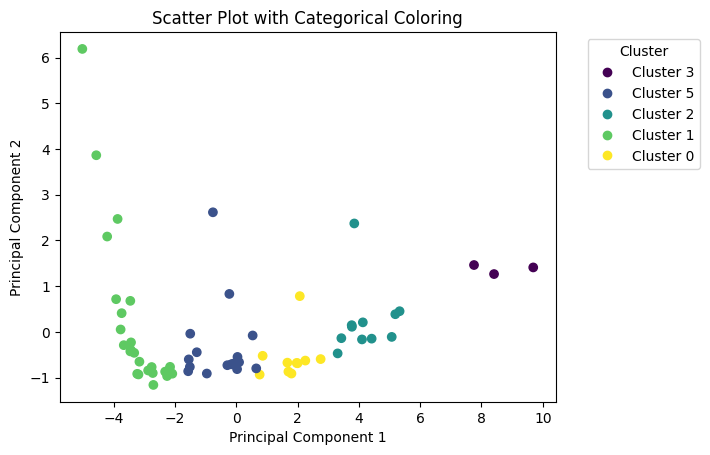

In [123]:
# Assuming you have a DataFrame df_reduced with 'Principal Component 1', 'Principal Component 2', and 'cluster' columns

# Scatter plot using Matplotlib
scatter = plt.scatter(df_reduced['Principal Component 1'], df_reduced['Principal Component 2'], c=df_reduced['cluster'].astype('category').cat.codes, cmap='viridis')

# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot with Categorical Coloring')

# Add legend outside the plot to the right
legend_labels = df_reduced['cluster'].unique()
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {label}' for label in legend_labels], title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [116]:
# Step 7: Explore the clustered zones
# You can analyze and visualize the clusters as needed
clustered_zones = new_df_dropped_outlier.groupby('cluster').apply(lambda x: x.index.tolist())
print("Clustered Zones:")
for i, zones in enumerate(clustered_zones):
    print(f"Cluster {i}: {zones}")

Clustered Zones:
Cluster 0: ['161', '236', '237']
Cluster 1: ['50', '75', '100', '113', '114', '137', '143', '144', '148', '151', '158', '211', '231', '233', '246', '262']
Cluster 2: ['48', '79', '141', '142', '162', '163', '170', '186', '230', '234', '239']
Cluster 3: ['4', '12', '13', '24', '41', '42', '45', '74', '87', '88', '116', '120', '125', '127', '128', '152', '153', '166', '202', '209', '224', '232', '243', '244', '261']
Cluster 4: ['43', '68', '90', '107', '140', '164', '229', '238', '249', '263']


In [117]:
new_df_dropped_outlier

,mean_all_time,median_all_time,std_dev_all_time,var_all_time,range_all_time,skewness_all_time,kurtosis_all_time,day_0_demand,day_1_demand,day_2_demand,day_3_demand,day_4_demand,day_5_demand,day_6_demand,cluster
4,5.092250,3.0,7.234677,52.340555,78.0,4.057958,21.456617,2.572354,3.077421,3.289966,3.957766,5.626971,9.615991,7.487461,3
12,1.681296,0.0,2.816058,7.930183,27.0,2.427855,7.178984,1.569820,1.471565,1.453231,1.437642,1.675113,2.325732,1.832911,3
13,23.323419,19.0,21.386085,457.364645,111.0,0.648357,-0.587599,20.610642,25.021396,27.371882,27.897392,24.697354,21.767736,15.949563,3
24,13.067787,13.0,9.740764,94.882476,63.0,0.406765,-0.631320,11.548986,12.997466,13.564342,14.099490,14.988176,13.267736,11.016906,3
41,13.623262,12.0,10.211069,104.265930,70.0,0.756278,0.246961,11.642173,12.706363,13.270975,13.979875,16.088119,15.173705,12.500704,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,61.948011,56.0,50.159207,2515.946032,350.0,0.825853,0.459407,51.132883,58.892455,62.695862,68.460601,60.936655,73.521959,58.041420,1
249,87.102084,75.0,68.938618,4752.532985,658.0,1.595729,3.937680,58.958615,70.205518,78.353458,85.441610,98.807432,126.121903,91.759651,5
261,19.741990,15.0,17.465276,305.035879,102.0,0.754021,-0.317981,17.211993,18.165259,19.886054,20.739229,20.476070,23.282095,18.439842,3
262,56.424979,53.0,44.860237,2012.440819,203.0,0.309625,-1.163215,53.110923,61.135135,63.644274,65.093821,63.777309,50.206081,38.099183,1


In [118]:
n_clusters = new_df_dropped_outlier['cluster'].nunique()

In [119]:
# Assuming statistical_features_df has 'cluster' column indicating the cluster for each zone

# Step 8: Find the zone closest to the cluster center for each cluster
closest_zones = []

# Iterate through each cluster
for i in range(n_clusters):
    cluster_zones = new_df[new_df['cluster'] == i].index

    # Calculate the mean of each feature for the cluster
    cluster_center = new_df.loc[cluster_zones, new_df.columns != 'cluster'].mean()

    # Calculate distance between each zone in the cluster and the cluster center
    distances = np.linalg.norm(new_df.loc[cluster_zones, new_df.columns != 'cluster'] - cluster_center, axis=1)

    # Find the zone with the minimum distance (closest to the cluster center)
    closest_zone = cluster_zones[np.argmin(distances)]
    closest_zones.append(closest_zone)

# Display the result
for i, closest_zone in enumerate(closest_zones):
    print(f"Cluster {i} - Closest Zone: {closest_zone}")


Cluster 0 - Closest Zone: 236
Cluster 1 - Closest Zone: 233
Cluster 2 - Closest Zone: 230
Cluster 3 - Closest Zone: 24
Cluster 4 - Closest Zone: 194
